## Лабораторная 1. Коннектом мозга человека

Дорогие студенты! 

В первой лабораторной работе мы предлагаем вам исследовать коннектом мозга человека, полученный в рамках проекта __[Human Connectome Project (HCP)](https://www.humanconnectome.org/)__ (в __[этой статье](https://link.springer.com/article/10.1007/s11571-017-9445-1)__).

Вам __[даны несколько файлов](https://drive.google.com/drive/folders/1aLmWQfYGP5jOa0cojA5zgpPP3sMeso_Li7r9KZaJ6GVSpMupYsIjeBmKa3oZ69LXiuSaWyul?usp=sharing)__ для одного и того же коннектома в различных разрешениях - на случай, если вы захотите подебажить код на маленьких графах, или использовать какие-нибудь очень тяжёлые алгоритмы.

Но, желательно представить итоговые результаты для самого большого разрешения коннектома.

Сумма баллов за все задания: `100`

In [2]:
from collections import defaultdict
from typing import Union
import os.path as osp
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import numpy as np

### Вспомогательные функции

In [3]:
def translate_key(
    key: str,
    map: dict[str, str] = None,
) -> str:
    """
    Translates a given key using a provided mapping dictionary. 
    If the key is not found in the mapping, the original key is returned.

    Args:
        key (str): 
            The key to be translated.
        map (dict[str, str], optional): 
            A dictionary where keys are original names and values are their translations.
            Defaults to an empty dictionary if not provided.

    Returns:
        str: The translated key if found in the dictionary; otherwise, the original key.
    """
    if map is None:
        map = {
            "Right": "Правое полушарие",
            "Left": "Левое полушарие",
            "Cortical": "Корковая область",
            "Subcortical": "Подкорковая область",
            "Parstriangularis": "Треугольная часть лобной доли",
            "Precentral": "Прецентральная извилина",
            "Superiorparietal": "Верхняя теменная область",
            "Lateraloccipital": "Латеральная затылочная область",
            "Entorhinal": "Энторинальная кора",
            "Left-pallidum": "Бледный шар (лев.)",
            "Right-pallidum": "Бледный шар (прав.)",
            "Posteriorcingulate": "Задняя поясная кора",
            "Caudalmiddlefrontal": "Задняя средняя лобная кора",
            "Right-thalamus-proper": "Таламус (прав.)",
            "Left-thalamus-proper": "Таламус (лев.)",
            "Left-amygdala": "Миндалина (лев.)",
            "Right-amygdala": "Миндалина (прав.)",
            "Parsopercularis": "Оперкулярная часть лобной доли",
            "Caudalanteriorcingulate": "Задняя передняя поясная кора",
            "Parsorbitalis": "Орбитальная часть лобной доли",
            "Medialorbitofrontal": "Медиальная орбитофронтальная кора",
            "Right-accumbens-area": "Область прилежащего ядра (прав.)",
            "Left-accumbens-area": "Область прилежащего ядра (лев.)",
            "Lingual": "Язычная извилина",
            "Right-caudate": "Хвостатое ядро (прав.)",
            "Left-caudate": "Хвостатое ядро (лев.)",
            "Postcentral": "Постцентральная извилина",
            "Temporalpole": "Полюс височной доли",
            "Precuneus": "Предклинье",
            "Middletemporal": "Средняя височная извилина",
            "Transversetemporal": "Поперечная височная извилина",
            "Insula": "Островковая кора",
            "Paracentral": "Парацентральная долька",
            "Left-putamen": "Путамен (лев.)",
            "Right-putamen": "Путамен (прав.)",
            "Lateralorbitofrontal": "Латеральная орбитофронтальная кора",
            "Isthmuscingulate": "Перешеек поясной коры",
            "Fusiform": "Веретенообразная извилина",
            "Rostralmiddlefrontal": "Ростральная средняя лобная кора",
            "Supramarginal": "Надкраевая извилина",
            "Right-hippocampus": "Гиппокамп (прав.)",
            "Left-hippocampus": "Гиппокамп (лев.)",
            "Cuneus": "Клиновидная кора",
            "Bankssts": "Область верхней височной борозды",
            "Frontalpole": "Полюс лобной доли",
            "Superiortemporal": "Верхняя височная извилина",
            "Inferiorparietal": "Нижняя теменная доля",
            "Pericalcarine": "Околошпорная кора",
            "Parahippocampal": "Парагиппокампальная извилина",
            "Brain-stem": "Ствол мозга",
            "Superiorfrontal": "Верхняя лобная извилина",
            "Rostralanteriorcingulate": "Ростральная передняя поясная кора",
            "Inferiortemporal": "Нижняя височная извилина",
        }

    return map.get(key, key)


def brain_area_function(
    brain_area_name: str,
    map: dict[str, str] = None,
) -> str:
    """
    Retrieves the function of a brain area by mapping its name through a provided dictionary. 
    If the brain area name is not found, returns the original name.

    Args:
        brain_area_name (str): 
            The name of the brain area.
        map (dict[str, str], optional): 
            A dictionary mapping brain area names to their respective functions.
            Defaults to an empty dictionary if not provided.

    Returns:
        str: The mapped function of the brain area if available, otherwise the original name.
    """
    if map is None:
        map = {
            "Cortical": "Высшие когнитивные функции, мышление",
            "Subcortical": "Регуляция движений, эмоции, память",
            "Parstriangularis": "Обработка речи, понимание языка",
            "Precentral": "Контроль движений (моторная кора)",
            "Superiorparietal": "Пространственное восприятие, внимание",
            "Lateraloccipital": "Обработка зрительной информации",
            "Entorhinal": "Формирование памяти, связь с гиппокампом",
            "Left-pallidum": "Движения, регулирование моторных функций",
            "Right-pallidum": "Движения, регулирование моторных функций",
            "Posteriorcingulate": "Память, внимание, ориентирование",
            "Caudalmiddlefrontal": "Планирование, когнитивный контроль",
            "Right-thalamus-proper": "Передача сенсорных сигналов в кору",
            "Left-thalamus-proper": "Передача сенсорных сигналов в кору",
            "Left-amygdala": "Эмоции, страх, агрессия",
            "Right-amygdala": "Эмоции, страх, агрессия",
            "Parsopercularis": "Производство речи, обработка звуков",
            "Caudalanteriorcingulate": "Контроль эмоций, принятие решений",
            "Parsorbitalis": "Регуляция поведения, социальные взаимодействия",
            "Medialorbitofrontal": "Обучение, оценка вознаграждения",
            "Right-accumbens-area": "Мотивация, система вознаграждения",
            "Left-accumbens-area": "Мотивация, система вознаграждения",
            "Lingual": "Обработка визуальной информации",
            "Right-caudate": "Контроль движений, обучение",
            "Left-caudate": "Контроль движений, обучение",
            "Postcentral": "Сенсорная информация, осязание",
            "Temporalpole": "Память, обработка эмоций",
            "Precuneus": "Сознание, самосознание, внимание",
            "Middletemporal": "Обработка слуха, зрительной информации",
            "Transversetemporal": "Анализ звуков и речи",
            "Insula": "Ощущения тела, эмоции, восприятие боли",
            "Paracentral": "Контроль движений ног и туловища",
            "Left-putamen": "Движения, формирование навыков",
            "Right-putamen": "Движения, формирование навыков",
            "Lateralorbitofrontal": "Контроль эмоций, принятие решений",
            "Isthmuscingulate": "Эмоции, память, регуляция поведения",
            "Fusiform": "Распознавание лиц, объектов",
            "Rostralmiddlefrontal": "Планирование, принятие решений",
            "Supramarginal": "Понимание речи, сенсомоторная интеграция",
            "Right-hippocampus": "Формирование долгосрочной памяти",
            "Left-hippocampus": "Формирование долгосрочной памяти",
            "Cuneus": "Обработка зрительных стимулов",
            "Bankssts": "Анализ речи, восприятие звуков",
            "Frontalpole": "Абстрактное мышление, планирование",
            "Superiortemporal": "Обработка речи и звуков",
            "Inferiorparietal": "Интеграция слуха, зрения, внимания",
            "Pericalcarine": "Первичная зрительная кора, обработка изображения",
            "Parahippocampal": "Память, ориентация в пространстве",
            "Brain-stem": "Жизненно важные функции (дыхание, сердце)",
            "Superiorfrontal": "Контроль внимания, моторное планирование",
            "Rostralanteriorcingulate": "Эмоции, контроль поведения",
            "Inferiortemporal": "Распознавание объектов, обработка зрительных образов",
        }

    return map.get(brain_area_name, brain_area_name)


def canonize_key(
    key: str,
) -> str:
    """
    Converts a given key into a standardized format by:
    - Removing hemisphere indicators (`lh`, `rh`).
    - Replacing periods with underscores.
    - Stripping numerical suffixes.
    - Capitalizing the first letter.

    Args:
        key (str): 
            The key to be standardized.

    Returns:
        str: A canonized version of the key.
        ```
    """
    splitted_key = list(filter(
        lambda s: s not in ['lh', 'rh'],
        key.lower().replace('.', '_').split('_')
    ))

    canonized_key = splitted_key[0] if splitted_key else key
    canonized_key = canonized_key.rstrip('0123456789').capitalize()

    return canonized_key


def get_neuron_info(
    neuron_data: dict[str, str],
    map: dict[str, str] = None,
) -> tuple[str, str, str, str]:
    """
    Extracts and standardizes neuron information, including its region, name, hemisphere, 
    and function, using optional mapping.

    Args:
        neuron_data (dict[str, str]): 
            A dictionary containing neuron attributes, including:
            - "dn_region": The region where the neuron is located.
            - "dn_name": The name of the neuron.
            - "dn_hemisphere": The hemisphere (left/right) where the neuron is located.
        map (dict[str, str], optional): 
            A dictionary mapping neuron attributes to their standardized values.
            Defaults to an empty dictionary if not provided.

    Returns:
        tuple[str, str, str, str]: A tuple containing:
            - Standardized region name.
            - Standardized neuron name.
            - Standardized hemisphere.
            - Mapped function of the neuron.
        ```
    """

    region = canonize_key(neuron_data.get('dn_region', 'N/A'))
    name = canonize_key(neuron_data.get('dn_name', 'N/A'))
    hemisphere = canonize_key(neuron_data.get('dn_hemisphere', 'N/A'))
    function = brain_area_function(name, map=map)

    return (
        translate_key(region, map=map),
        translate_key(name, map=map),
        translate_key(hemisphere, map=map),
        function,
    )


In [4]:
def get_node_colors(
    node_attrs: list,
) -> list:
    """
    Assigns RGB colors to unique node attributes and returns a list of corresponding colors.

    Args:
        node_attrs (list): 
            A list of node attributes, where each attribute represents a category. 
            Nodes with the same attribute will be assigned the same color.

    Returns:
        list: 
            A list of RGB color strings (formatted as "rgb(R, G, B)") corresponding to each 
            attribute in the input list.
    """

    # Obtain unique attributes
    unique_attrs = list(set(node_attrs))

    # Assign RGB colors to the attributes
    cmap = plt.get_cmap("turbo", len(unique_attrs))
    color_map = {
        attr: f"rgb({int(cmap(i)[0]*255)}, {int(cmap(i)[1]*255)}, {int(cmap(i)[2]*255)})"
        for i, attr in enumerate(unique_attrs)
    }

    # Assign corresponding colors to the nodes
    node_colors = [color_map[attr] for attr in node_attrs]

    return node_colors


In [5]:
def plot_connectome(
    G: nx.Graph,
    node_colors: Union[str, list[str]] = 'red',
    show_legend: bool = True,
):
    """
    Plots a 3D connectome graph based on node positions and connectivity.

    Args:
        G: 
            A NetworkX graph containing nodes with attributes 'dn_position_x', 
            'dn_position_y', and 'dn_position_z'.
        node_colors (str or list, optional): 
            The color(s) assigned to nodes. Can be a single color or a list matching 
            the number of nodes.
        show_legend (bool, optional): 
            Whether to display a legend grouping nodes by color. Defaults to True.

    Returns:
        None: Displays an interactive 3D plot of the connectome.
    """

    # Extract node positions
    positions = {node: (
        float(data['dn_position_x']),
        float(data['dn_position_y']),
        float(data['dn_position_z'])
        )
        for node, data in G.nodes(data=True)
    }

    # Edges coordinates
    edge_x = []
    edge_y = []
    edge_z = []

    for edge in G.edges():
        x0, y0, z0 = positions[edge[0]]
        x1, y1, z1 = positions[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    # Nodes coordinates
    node_x = [pos[0] for pos in positions.values()]
    node_y = [pos[1] for pos in positions.values()]
    node_z = [pos[2] for pos in positions.values()]

    # Additional node info
    node_info = [
        "Region: {0}<br>Name: {1}<br>Hemisphere: {2}<br>Function: {3}".format(*get_neuron_info(data))
        for node, data in G.nodes(data=True)
    ]

    # Create 3D plot
    fig = go.Figure(layout={'width': 1200, 'height': 800})

    # Plot edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgba(0, 0, 255, 0.1)', width=1),
        name='edges',
        hoverinfo='skip',
        showlegend=False,
    ))

    # Plot nodes
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(size=5, color=node_colors),
        text=node_info,
        hoverinfo='text',
        name='nodes',
        showlegend=False,
    ))

    # Configure plot appearance
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title="Brain Connectome"
    )

    # Group nodes by color for legend
    color_groups = defaultdict(list)
    for node, color in zip(G.nodes(), node_colors):
        region, name, hemisphere, function = get_neuron_info(G.nodes[node])
        color_groups[color].append(name)

    if show_legend:
        for color, nodes in color_groups.items():
            fig.add_trace(go.Scatter3d(
                x=[None], y=[None], z=[None],
                mode='markers',
                marker=dict(size=5, color=color),
                name=f"{'<br>'.join(set(nodes))}",
                hoverinfo='skip',
                legendwidth=3,
            ))

        fig.update_layout(
            legend=dict(
                x=1.05,
                y=1,
                xanchor="left",
                yanchor="top",
                bgcolor="rgba(255, 255, 255, 0.7)",
                font=dict(size=10),
                itemwidth=30,
                bordercolor="black",
                borderwidth=1,
                tracegroupgap=5,
            )
        )

    fig.show()


## 0. Пример работы с коннектомом

In [6]:
graph_path = osp.join(".", "brain_23_scale500.graphml")
G = nx.read_graphml(graph_path)

In [7]:
# Extract unique regions and assign colors
color_by='dn_name'
node_names = [
    canonize_key(data.get(color_by, 'Unknown'))
    for node, data in G.nodes(data=True)
]
node_colors = get_node_colors(node_names)

# Plot the connectome
plot_connectome(G, node_colors=node_colors)

## Задание 1. Анализ графа (25 баллов)

### 1.1. Основные характеристики графа, коэффициент кластеризации

- Выделите из графа наибольшую связную компоненту. Здесь и далее в лабораторной мы будем работать с ней.

- Посчитайте основные характеристики графа (коэффициент кластеризации, диаметр, радиус, среднюю длину кратчайшего пути)

- Постройте гистограмму распределения коэффициентов кластеризации отдельных вершин

- Постройте график зависимости коэффициента кластеризации от степени вершины

In [8]:
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

In [9]:
average_clustering = nx.average_clustering(G)

diameter = nx.diameter(G)
radius = nx.radius(G)

avg_shortest_path = nx.average_shortest_path_length(G)

print("Средний коэффициент кластеризации:", average_clustering)
print("Диаметр:", diameter)
print("Радиус:", radius)
print("Средняя длина кратчайшего пути:", avg_shortest_path)

Средний коэффициент кластеризации: 0.6296118467082773
Диаметр: 9
Радиус: 5
Средняя длина кратчайшего пути: 3.159306449894202


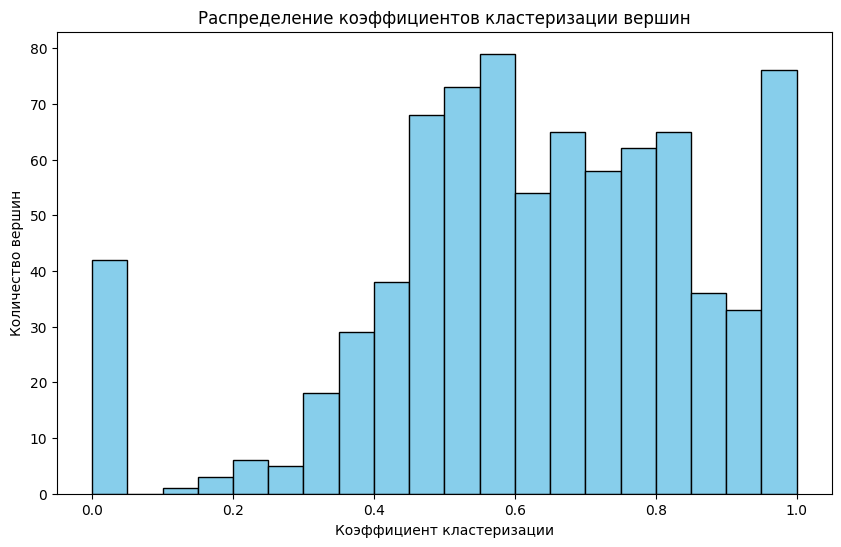

In [10]:
clustering_coeffs = list(nx.clustering(G).values())

plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение коэффициентов кластеризации вершин')
plt.xlabel('Коэффициент кластеризации')
plt.ylabel('Количество вершин')
plt.show()

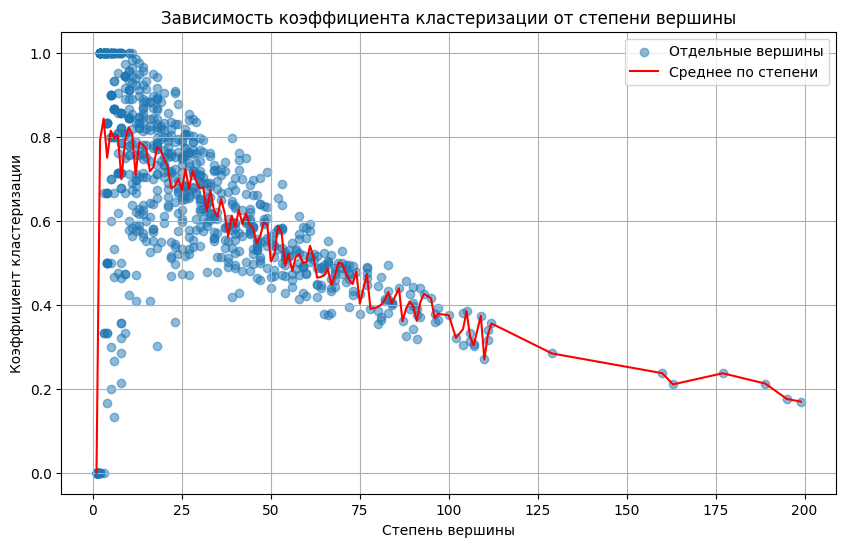

In [11]:
degrees = dict(G.degree())
clusterings = nx.clustering(G)
deg = [degrees[node] for node in G.nodes()]
clus = [clusterings[node] for node in G.nodes()]

degree_clusters = defaultdict(list)
for node in G.nodes():
    degree = degrees[node]
    clust = clusterings[node]
    degree_clusters[degree].append(clust)

avg_clust = {k: np.mean(v) for k, v in degree_clusters.items()}
sorted_degrees = sorted(avg_clust.keys())
sorted_avg = [avg_clust[k] for k in sorted_degrees]

plt.figure(figsize=(10, 6))
plt.scatter(deg, clus, alpha=0.5, label='Отдельные вершины')
plt.plot(sorted_degrees, sorted_avg, color='red', label='Среднее по степени')
plt.title('Зависимость коэффициента кластеризации от степени вершины')
plt.xlabel('Степень вершины')
plt.ylabel('Коэффициент кластеризации')
plt.legend()
plt.grid(True)
plt.show()

### 1.2. Длина пути

- Посчитайте среднюю длину кратчайшего пути между двумя вершинами графа

- Постройте гистограмму зависимости средней длины кратчайшего пути от степени вершины

In [12]:
print("Средняя длина кратчайшего пути:", avg_shortest_path)

Средняя длина кратчайшего пути: 3.159306449894202


In [13]:
n = G.number_of_nodes()
node_avg_paths = {}

for node in G.nodes():
    path_lengths = nx.single_source_shortest_path_length(G, node)
    total_length = sum(path_lengths.values())
    node_avg_paths[node] = total_length / (n - 1)

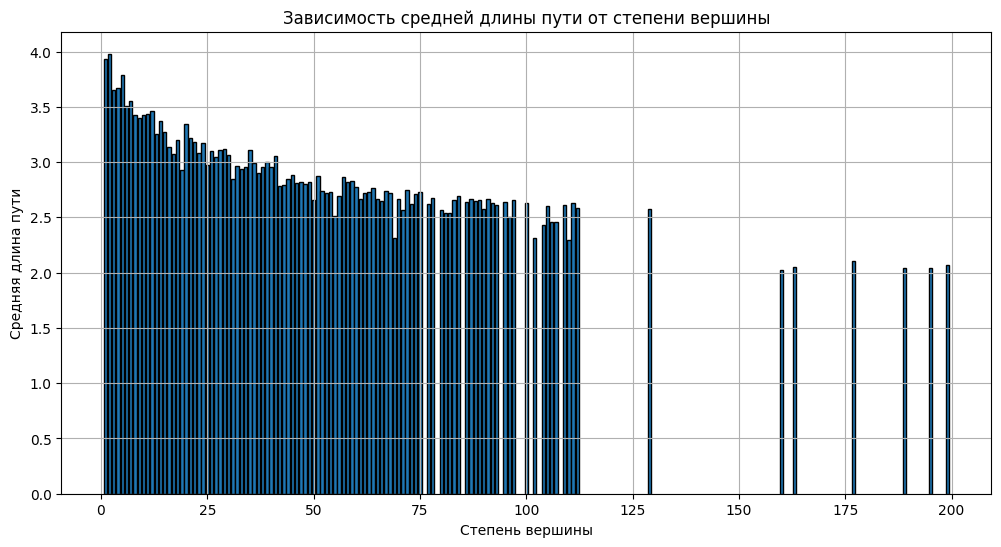

In [14]:
degrees = dict(G.degree())
degree_groups = defaultdict(list)

for node, avg_path in node_avg_paths.items():
    degree_groups[degrees[node]].append(avg_path)

degree_avg_path = {k: np.mean(v) for k, v in degree_groups.items()}
sorted_degrees = sorted(degree_avg_path.keys())
sorted_avg_paths = [degree_avg_path[d] for d in sorted_degrees]

plt.figure(figsize=(12, 6))
plt.bar(sorted_degrees, sorted_avg_paths, width=0.8, edgecolor='black')
plt.title('Зависимость средней длины пути от степени вершины')
plt.xlabel('Степень вершины')
plt.ylabel('Средняя длина пути')
plt.grid(True)
plt.show()

### 1.3. Распределение степеней вершин

- Какое распределение имеют степени вершин? Проведите анализ распределения степенй вершин и найдите параметры этого распределения

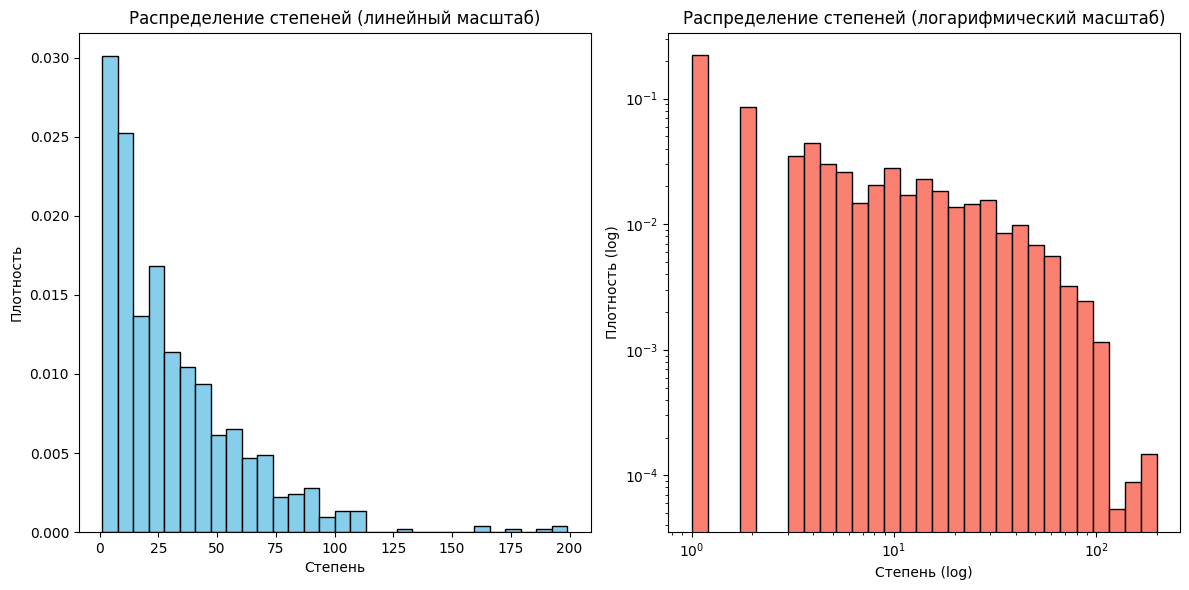

In [15]:
degrees = dict(G.degree()).values()
degrees = list(degrees)
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.hist(degrees, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title("Распределение степеней (линейный масштаб)")
plt.xlabel("Степень")
plt.ylabel("Плотность")

plt.subplot(122)
plt.hist(degrees, bins=np.logspace(0, np.log10(max(degrees)), 30), density=True, color='salmon', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Распределение степеней (логарифмический масштаб)")
plt.xlabel("Степень (log)")
plt.ylabel("Плотность (log)")

plt.tight_layout()
plt.show()

In [16]:
import powerlaw
import random

Calculating best minimal value for power law fit
альфа: 5.283788040911669
xmin: 77.0
p-value: <bound method Distribution.KS of <powerlaw.Power_Law object at 0x0000012B20992CF0>>


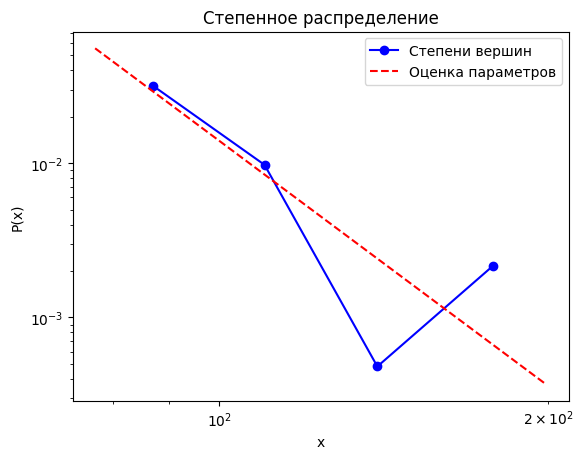

In [17]:
#ata = np.random.pareto(2, 1000) + 1
data = np.array(degrees)
fit = powerlaw.Fit(data)

print("альфа:", fit.power_law.alpha)
print("xmin:", fit.power_law.xmin)
print("p-value:", fit.power_law.KS)
alpha_true = fit.power_law.alpha
xmin_true = fit.power_law.xmin

fig = fit.plot_pdf(color='b', marker='o', label='Степени вершин')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Оценка параметров')
plt.legend()
plt.xlabel("x")
plt.ylabel("P(x)")
plt.title("Степенное распределение")
plt.show()


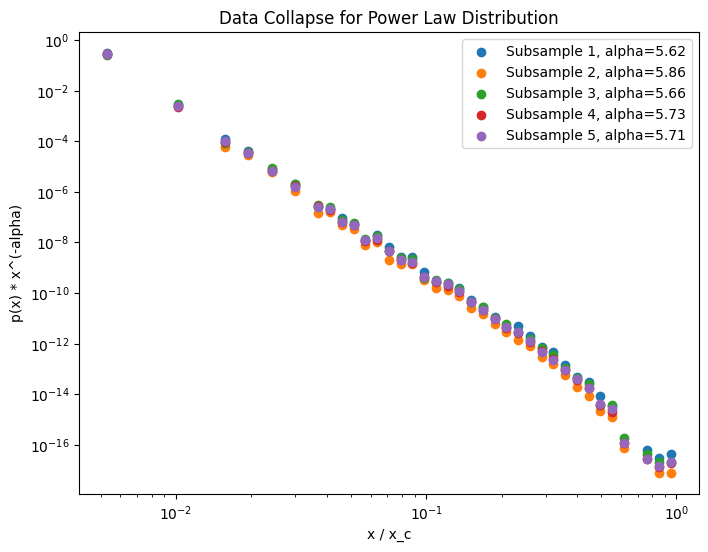

In [18]:
plt.figure(figsize=(8, 6))
random.seed(3)
sample_sizes=[0.7, 0.75, 0.8, 0.85, 0.9]
subsamples = []
for size in sample_sizes:
    n = int(len(data) * size)
    subsample = np.array(random.sample(sorted(data), n))
    subsample.sort()
    subsamples.append(subsample)

for i, subsample in enumerate(subsamples):
    fit = powerlaw.Fit(subsample, verbose=False)
    alpha = fit.power_law.alpha
    x_c = subsample.max()
    bins = np.logspace(np.log10(subsample.min()), np.log10(x_c), num=50)
    hist, bin_edges = np.histogram(subsample, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    scaled_x = bin_centers / x_c
    scaled_y = hist * (bin_centers ** (-alpha))
    scaled_y = scaled_y

    plt.scatter(scaled_x, scaled_y, marker='o', linestyle='-',
             label=f'Subsample {i+1}, alpha={alpha:.2f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('x / x_c')
plt.ylabel('p(x) * x^(-alpha)')
plt.title('Data Collapse for Power Law Distribution')
plt.legend()
plt.show()

Clauset-Shalizi-Newman дает оценку alpha = 5.28, xmin = 77, а график случайных подвыборок в соответствующих масштабах представляет единую прямую, иллюстрируя коллапс данных, что подтверждает нашу оценку- закон распределения степенной, с alpha = 5.28, xmin = 77

### 1.4. Определите, какие в нашем мозге наиболее важные и значимые нейроны?

Вообще, рассмотрим разные метрики, потому что нейрон может быть значимым в разных смыслах.

In [19]:
betweenness_cent = nx.betweenness_centrality(G)
sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)

[('502', 0.16193498134711048),
 ('503', 0.144205040271197),
 ('1008', 0.1417098118419423),
 ('1009', 0.13222515257013004),
 ('1010', 0.10036630817694246),
 ('1013', 0.08845647450254364),
 ('504', 0.07798693877419222),
 ('507', 0.05102869464747398),
 ('151', 0.031662638038162674),
 ('768', 0.02419557426245252),
 ('631', 0.022799588224031962),
 ('99', 0.022777100910673597),
 ('486', 0.022584348484334396),
 ('888', 0.02125344240272725),
 ('191', 0.02113209586322315),
 ('806', 0.02028907542058122),
 ('712', 0.02000079999661108),
 ('276', 0.017047436647245045),
 ('284', 0.01704698920173666),
 ('769', 0.01626679580002252),
 ('964', 0.014026876711551516),
 ('970', 0.01393359358078192),
 ('991', 0.012328853022464479),
 ('697', 0.011768970862534306),
 ('385', 0.010891467730509549),
 ('223', 0.010801765229440574),
 ('1011', 0.010725503278775542),
 ('967', 0.010458863702761745),
 ('959', 0.010151111848960503),
 ('359', 0.009921776162909292),
 ('706', 0.009683742662780262),
 ('258', 0.009664699297

In [20]:
eigen_cent = nx.eigenvector_centrality(G, max_iter=1000)
sorted(eigen_cent.items(), key=lambda x: x[1], reverse=True)

[('503', 0.18374291093105533),
 ('504', 0.18150013497050357),
 ('502', 0.16357715864512198),
 ('235', 0.13589099765397133),
 ('494', 0.12979095427534795),
 ('255', 0.12900782521222093),
 ('145', 0.12552268980195985),
 ('487', 0.11933899175074483),
 ('256', 0.11869911347542404),
 ('284', 0.11714381425967076),
 ('179', 0.11647811629209551),
 ('254', 0.11546026673371267),
 ('117', 0.11290056588393899),
 ('198', 0.1124238584615851),
 ('493', 0.11068443053564228),
 ('132', 0.10877462669354972),
 ('46', 0.10756056187157614),
 ('205', 0.10692684676873028),
 ('236', 0.106702613930412),
 ('495', 0.10599175384022537),
 ('237', 0.10449889714969612),
 ('326', 0.10389695451617663),
 ('146', 0.1019163370411693),
 ('258', 0.10179774241916305),
 ('505', 0.10093211720168871),
 ('507', 0.09956322176598056),
 ('253', 0.09907488395731756),
 ('455', 0.09880262115695679),
 ('192', 0.09782641836116208),
 ('151', 0.09636077512953835),
 ('327', 0.09621848526827033),
 ('313', 0.09335742759871248),
 ('176', 0.09

In [21]:
pagerank = nx.pagerank(G)
sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

[('1010', 0.007745568312445365),
 ('1009', 0.007213486535304315),
 ('503', 0.006191050971121689),
 ('504', 0.005839830775365151),
 ('1008', 0.005667763103260392),
 ('502', 0.0050913826776881966),
 ('1013', 0.004705351462338685),
 ('284', 0.004406413986121507),
 ('806', 0.004144762765074424),
 ('661', 0.003933554517862653),
 ('507', 0.003782079403922899),
 ('770', 0.0037512803475963233),
 ('769', 0.003688054668086541),
 ('631', 0.0036589449966345487),
 ('1011', 0.0035990712328217195),
 ('256', 0.003595435806880654),
 ('145', 0.0034887902945754806),
 ('235', 0.003482143450415212),
 ('657', 0.003392448398954939),
 ('255', 0.0033512123505309607),
 ('888', 0.00334768639388103),
 ('731', 0.0033386815679041907),
 ('758', 0.003288621792651243),
 ('959', 0.0032881038705249253),
 ('455', 0.0032818097355397087),
 ('494', 0.0032399141308401295),
 ('837', 0.0032181619416423763),
 ('151', 0.0031915068683442613),
 ('991', 0.0031605673422056024),
 ('132', 0.0031083924337987436),
 ('198', 0.00309092970

Сразу видим, что 502-504 много где высоко в топе, но посмотрим по сумме рейтингов какие высоки во всех категориях

In [22]:
import pandas as pd

df = pd.DataFrame({
    'betweenness': betweenness_cent,
    'eigenvector': eigen_cent,
    'pagerank': pagerank
})
df['total_centrality'] = df.sum(axis=1)

top_neurons = df.sort_values('total_centrality')
top_neurons.tail(10)

betweenness  eigenvector  pagerank  total_centrality
284      0.017047     0.117144  0.004406          0.138597
255      0.008963     0.129008  0.003351          0.141322
235      0.007125     0.135891  0.003482          0.146498
1010     0.100366     0.040535  0.007746          0.148647
507      0.051029     0.099563  0.003782          0.154374
1009     0.132225     0.046940  0.007213          0.186379
1008     0.141710     0.051723  0.005668          0.199101
504      0.077987     0.181500  0.005840          0.265327
502      0.161935     0.163577  0.005091          0.330604
503      0.144205     0.183743  0.006191          0.334139

### 1.5. Является ли мозг человека сложной сетью? Почему?

Знаем некоторые характеристики сложной сети:
1. Степенное распределение степеней вершин - проверили это
2. Small world - диаметр асимптотически мал. С разрешения 250 на 500 диаметр увеличился на 3, так что можно утверждать, что он асимптотически мал. Средний кратчайший путь вообще 3, тоже мал
3. Высокая кластеризация- большинство вершин имеют кластеризацию выше 0.5
4. Выраженные структуры сообществ - пока не проверили, но уже есть некая разметка в виде областей, которые можно считать сообществами
Вывод: сеть мозга человека отвечает всем характеристикам сложной сети, и является сложной сетью.

## Задание 2. Разметка коннектома мозга (30 баллов)

- Постройте автоматическую разметку конектома мозга. Под разметкой имеется в виду разделение коннектома на некоторое число областей, и соотнесение каждой вершины с одной из областей.

- Попробуйте несколько различных алгоритмов разметки. Если у алгоритмов есть параметры - опишите, как вы выбирали их значения

- Сравните результаты работы алгоритмов между собой, и с истинной разметкой

In [23]:
from community import community_louvain
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from networkx.algorithms.community import label_propagation_communities
from sklearn.preprocessing import LabelEncoder

In [24]:
node_info = [
        get_neuron_info(data)[1]
        for node, data in G.nodes(data=True)
    ]

encoder = LabelEncoder()
true_labels = encoder.fit_transform(node_info)
print(true_labels)

[13 13 14 14 41 41 41 41 41 24 24 24 24 24 24 24 24 24 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 27 27 27 27 27 27 27 27 27 27 27 35 35 35  8  8
  8  8  8  8  9  9  9  9  9  9  9  9 28 28 28 28 28 28 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 11 11 11 11
 11 11 11 23 23 23 23 23 23 23 23 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 44 44 44 44 44 44 44 44 44 44 44

In [25]:
def louvain_clustering(graph):
    partition = community_louvain.best_partition(graph, resolution=6)
    return list(partition.values())

def spectral_clustering(graph, n_clusters):
    adj_matrix = nx.to_numpy_array(graph)
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    return sc.fit_predict(adj_matrix)

def greedy_modularity_clustering(graph):
    communities = nx.algorithms.community.greedy_modularity_communities(graph)
    nodes = list(graph.nodes())
    partitions = np.zeros(len(nodes), dtype=int)
    for i, comm in enumerate(communities):
        for node in comm:
            node_index = nodes.index(node)
            partitions[node_index] = i
    return partitions

def label_propagation_clustering(graph):
    communities = list(label_propagation_communities(graph))
    nodes = list(graph.nodes())
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    partitions = np.zeros(len(nodes), dtype=int)
    for i, comm in enumerate(communities):
        for node in comm:
            partitions[node_to_idx[node]] = i
    return partitions

def evaluate_clustering(true, pred, method_name):
    ari = adjusted_rand_score(true, pred)
    nmi = normalized_mutual_info_score(true, pred)
    print(f"{method_name}:")
    print(f"Adjusted Rand Index: {ari:.3f}")
    print(f"Normalized Mutual Info: {nmi:.3f}\n")

n_clusters = len(np.unique(true_labels))

methods = {
    "Louvain": louvain_clustering,
    "Spectral": lambda G: spectral_clustering(G, n_clusters),
    "Greedy Modularity": greedy_modularity_clustering,
    "Label Propagation": label_propagation_clustering,
}

results = {}
for name, method in methods.items():
    results[name] = method(G)

print("Результатыs:")
for name, pred in results.items():
    evaluate_clustering(true_labels, pred, name)

print("\nСравнение алгоритмов:")
methods_list = list(methods.keys())
for i in range(len(methods_list)):
    for j in range(i+1, len(methods_list)):
        print(f"{methods_list[i]} vs {methods_list[j]}:")
        evaluate_clustering(results[methods_list[i]], results[methods_list[j]], "")

Результатыs:
Louvain:
Adjusted Rand Index: 0.224
Normalized Mutual Info: 0.584

Spectral:
Adjusted Rand Index: 0.019
Normalized Mutual Info: 0.394

Greedy Modularity:
Adjusted Rand Index: 0.001
Normalized Mutual Info: 0.057

Label Propagation:
Adjusted Rand Index: 0.080
Normalized Mutual Info: 0.270


Сравнение алгоритмов:
Louvain vs Spectral:
:
Adjusted Rand Index: 0.067
Normalized Mutual Info: 0.548

Louvain vs Greedy Modularity:
:
Adjusted Rand Index: 0.072
Normalized Mutual Info: 0.367

Louvain vs Label Propagation:
:
Adjusted Rand Index: 0.084
Normalized Mutual Info: 0.407

Spectral vs Greedy Modularity:
:
Adjusted Rand Index: 0.083
Normalized Mutual Info: 0.298

Spectral vs Label Propagation:
:
Adjusted Rand Index: 0.026
Normalized Mutual Info: 0.313

Greedy Modularity vs Label Propagation:
:
Adjusted Rand Index: 0.183
Normalized Mutual Info: 0.375



In [26]:
communities = results["Louvain"]
print(communities)
print(n_clusters)

[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 4, 2, 2, 4, 4, 5, 5, 4, 5, 5, 5, 2, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 6, 6, 6, 6, 7, 6, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 8, 5, 8, 8, 1, 9, 0, 10, 3, 10, 3, 10, 3, 3, 10, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 8, 6, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 15, 16, 6, 6, 6, 6, 6, 6, 6, 6, 6, 15, 15, 6, 6, 6, 6, 6, 17, 18, 19, 19, 8, 8, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 19, 22, 23, 16, 16, 16, 22, 22, 22, 17, 17, 22, 22, 22, 22, 23, 16, 23, 23, 23, 20, 22, 17, 20, 20, 20, 20, 17, 13, 13, 19, 19, 19, 13, 13, 19, 19, 19, 19, 19, 19, 19, 19, 17, 19, 19, 19, 8, 20, 20, 20, 20, 20, 20, 23, 23, 20, 20, 20, 23, 23, 

Видим, что для данного графа Лувен работает лучше всего, но все равно не очень хорошо. Параметры подобраны так, чтобы генерировалось около того количества кластеров, как нужно.

## Задание 3. Ассортативность (15 баллов)

- Рассмотрите:
  - Коннектом целиком
  - Различные области, найденные с помощью автоматической разметки, по отдельности
- Посчитайте для них ассортативность, постройте необходимые графики
- Проанализируйте результаты

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning:

invalid value encountered in scalar divide



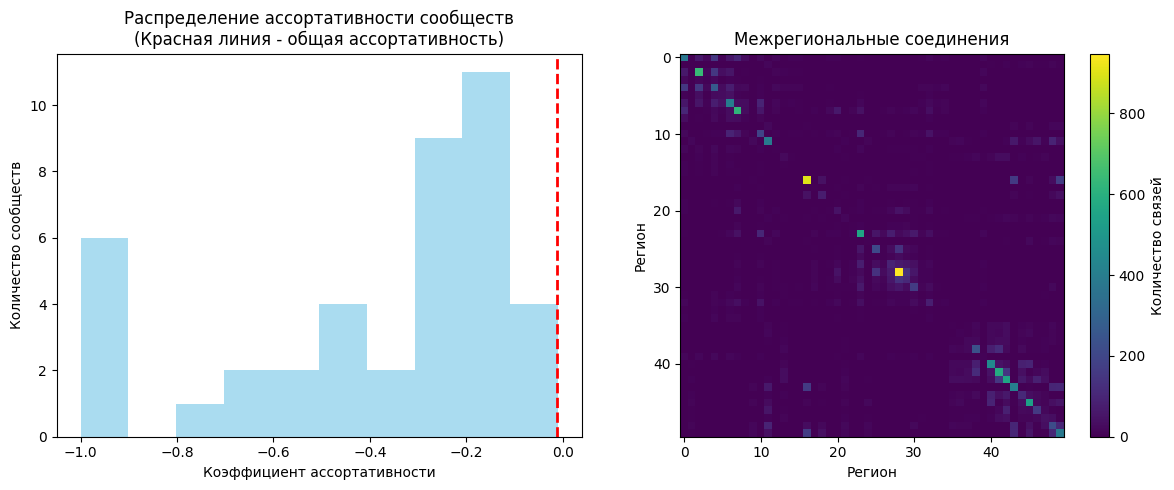

Общая ассортативность сети: -0.011
Средняя ассортативность сообщесты: -0.392
Медианная ассортативность сообществ: -0.253


In [27]:
partition = community_louvain.best_partition(G, resolution = 6)
regions = list(partition.values())

global_assortativity = nx.degree_assortativity_coefficient(G)

region_assortativity = {}
unique_regions = list(set(regions))

for region in unique_regions:
    nodes_in_region = [n for n in G.nodes() if partition[n] == region]
    subgraph = G.subgraph(nodes_in_region)
    
    if len(subgraph) > 2:
        try:
            assort = nx.degree_assortativity_coefficient(subgraph)
            region_assortativity[region] = assort
        except nx.NetworkXError:
            region_assortativity[region] = None

plt.figure(figsize=(12, 5))

plt.subplot(121)
valid_values = [v for v in region_assortativity.values() if v is not None]
plt.hist(valid_values, bins=10, alpha=0.7, color='skyblue')
plt.axvline(global_assortativity, color='red', linestyle='dashed', linewidth=2)
plt.title('Распределение ассортативности сообществ\n(Красная линия - общая ассортативность)')
plt.xlabel('Коэффициент ассортативности')
plt.ylabel('Количество сообществ')

plt.subplot(122)
adj_matrix = np.zeros((len(unique_regions), len(unique_regions)))

for u, v in G.edges():
    ru = partition[u]
    rv = partition[v]
    adj_matrix[ru, rv] += 1
    adj_matrix[rv, ru] += 1

plt.imshow(adj_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Количество связей')
plt.title('Межрегиональные соединения')
plt.xlabel('Регион')
plt.ylabel('Регион')

plt.tight_layout()
plt.show()
print(f"Общая ассортативность сети: {global_assortativity:.3f}")
print(f"Средняя ассортативность сообщесты: {np.nanmean(valid_values):.3f}")
print(f"Медианная ассортативность сообществ: {np.nanmedian(valid_values):.3f}")

Наш коннектом имеет ассортативность близкую к 0, но сообщества имеют средние ассортативности ниже, значит наша разметка разбивает хабы по разным сообществам. Тем не менее, межрегиональные связи тоже низки, значит соседи хабов разбиваются на разные сообщества.

## Задание 4. Транскраниальная магнитная стимуляция (30 баллов)

__[Транскраниальная магнитная стимуляция (ТМС)](https://ru.wikipedia.org/wiki/Транскраниальная_магнитная_стимуляция)__ - метод, позволяющий неинвазивно стимулировать кору головного мозга. Он применяется для реабелитации пациентов (например, с двигательными нарушениями), и для лечения различных заболеваний: болезни Паркинсона, эпилепсии, депрессии, шизофрении, и других.

Мы предлагаем вам провести ТМС вашего "пациента". Для этого нужно:

- "Взвесить" рёбра графа. Например, используя некоторую метрику, убывающую с ростом расстояния между вершинами

- Применить ТМС к различным областям мозга. Посмотреть, как далеко распространится сигнал, какие области затронет, за какие функции отвечают эти области.

  Для реализации распространения сигналов можно использовать различные методы: `message passing`, `random walk`, `heat diffusion` и другие.

  Попробуйте различные методы (два или больше), сравните результаты.

---

Чтобы выбрать, к каким областям мозга применять ТМС, можете использовать научные статьи, например: 

__[Evidence-based guidelines on the therapeutic use of repetitive transcranial magnetic stimulation (rTMS)](https://www.sciencedirect.com/science/article/pii/S1388245719312799?via%3Dihub)__. 

В этой статье приведено множество исследований, в которых стимулировали различные области мозга при помощи ТМС. Также, описаны симптомы пациентов и результаты применения ТМС.

---

Например, на картинке ниже вы можете видеть:

- Симптом пациентов - двигательное нарушение руки в результате инсульта

- Область применения ТМС - зона M1. Для ориентации в шифрах областей можете использовать __[карту областей мозга](https://atlas.brain-map.org/atlas?atlas=265297126)__

- Результат терапии - улучшение двигательных функций

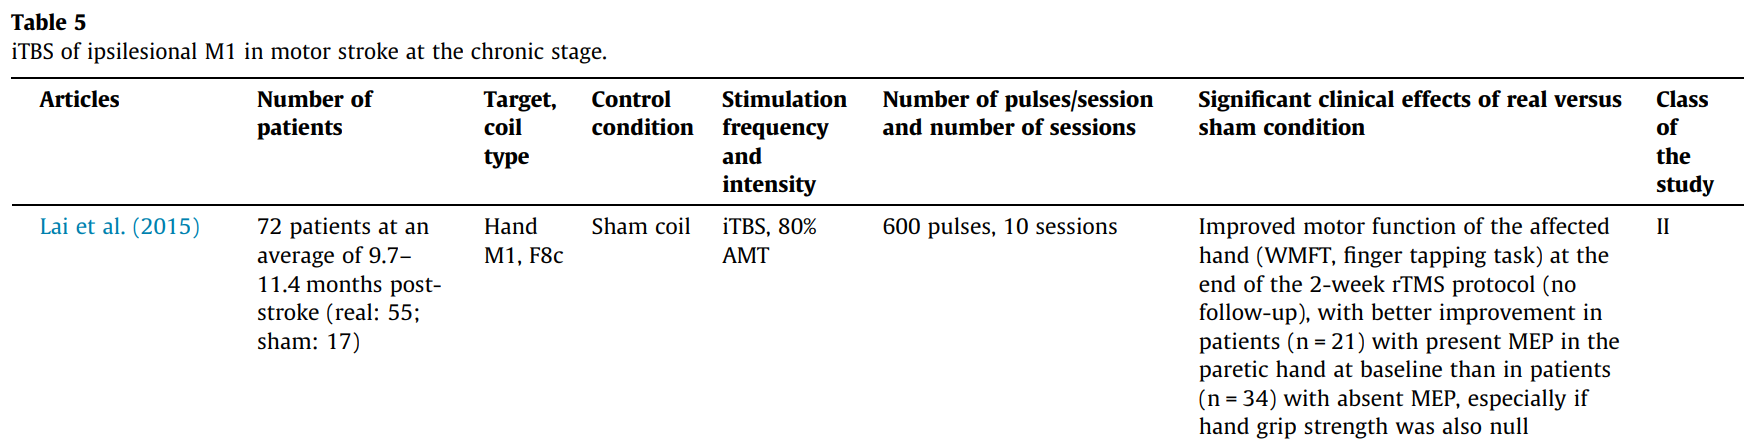

---

Удачи Вам в работе!

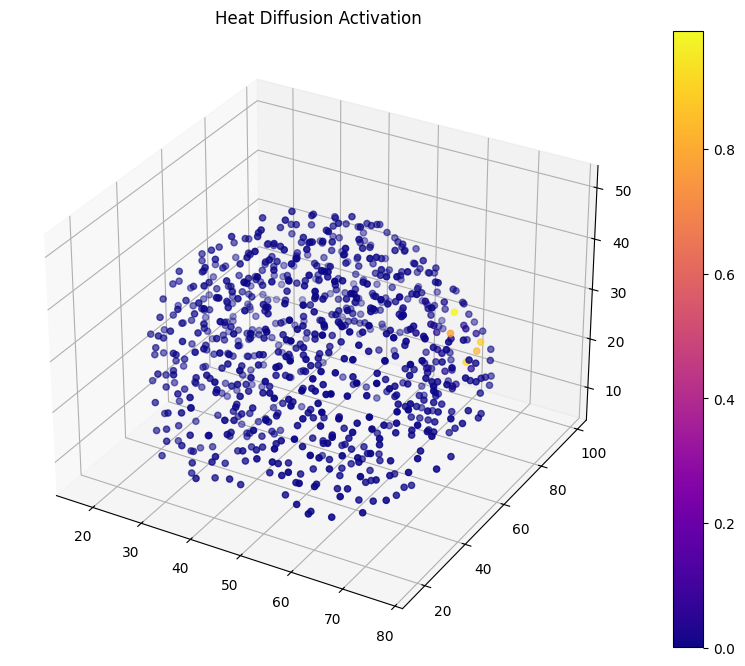

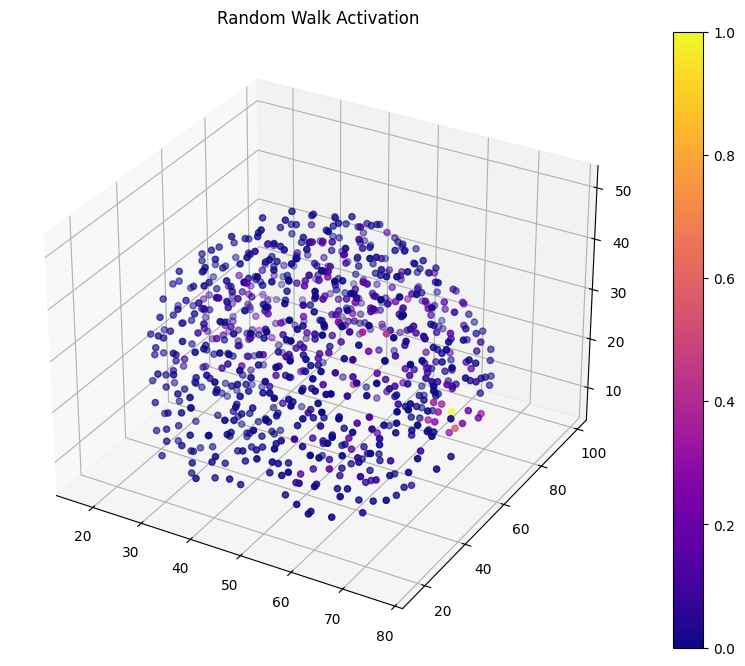

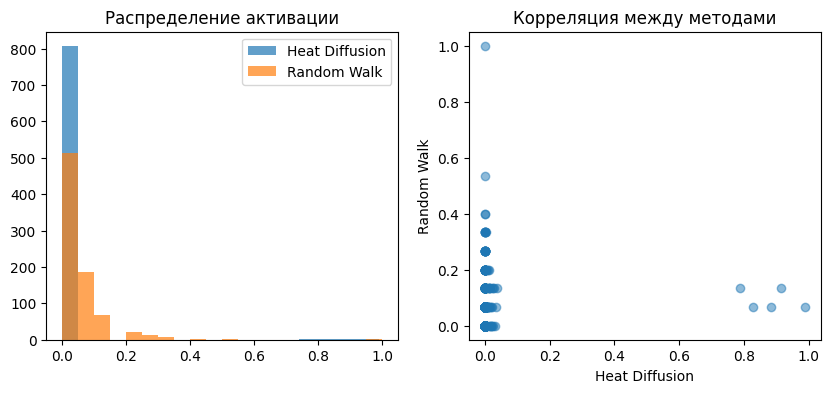

Корреляция: 0.06


In [31]:
from scipy.sparse.linalg import expm

pos = {n: (data['dn_position_x'], data['dn_position_y'], data['dn_position_z']) for n, data in G.nodes(data=True)}

def add_distance_weights(graph):
    for u, v in graph.edges():
        x1, y1, z1 = graph.nodes[u]['dn_position_x'], graph.nodes[u]['dn_position_y'], graph.nodes[u]['dn_position_z']
        x2, y2, z2 = graph.nodes[v]['dn_position_x'], graph.nodes[v]['dn_position_y'], graph.nodes[v]['dn_position_z']
        dist = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
        graph[u][v]['weight'] = 1.0 / (dist + 1e-6)
    return graph

G = add_distance_weights(G)

# 2. Определение целевой области (M1 - первичная моторная кора)
def find_m1_nodes(graph):
    m1_nodes = []
    for n in graph.nodes():
        if graph.nodes[n]['dn_position_z'] > 25 and graph.nodes[n]['dn_position_x'] > 70:
            m1_nodes.append(n)
    return m1_nodes[:5]

stimulation_nodes = find_m1_nodes(G)
def heat_diffusion(graph, sources, alpha=0.1, time=1.0):
    nodes = list(graph.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    
    L = nx.laplacian_matrix(graph, nodelist=nodes).astype(float)
    L = -alpha * L
    heat = np.zeros(n)
    
    for node in sources:
        heat[node_index[node]] = 1.0
    solution = expm(L * time).dot(heat)
    return {node: solution[i] for i, node in enumerate(nodes)}

def weighted_random_walk(graph, sources, steps=100):
    activation = {n: 0.0 for n in graph.nodes()}
    
    for start_node in sources:
        current = start_node
        activation[current] += 1.0
        
        for _ in range(steps):
            neighbors = list(graph.neighbors(current))
            weights = [graph[current][n]['weight'] for n in neighbors]
            total = sum(weights)
            if total == 0:
                break
            probs = [w/total for w in weights]
            current = np.random.choice(neighbors, p=probs)
            activation[current] += 1.0
    
    max_act = max(activation.values())
    return {n: act/max_act for n, act in activation.items()}

hd_result = heat_diffusion(G, stimulation_nodes)
rw_result = weighted_random_walk(G, stimulation_nodes)

def plot_3d_activation(graph, activation_dict, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    xs = [data['dn_position_x'] for _, data in graph.nodes(data=True)]
    ys = [data['dn_position_y'] for _, data in graph.nodes(data=True)]
    zs = [data['dn_position_z'] for _, data in graph.nodes(data=True)]
    colors = [activation_dict[n] for n in graph.nodes()]
    
    sc = ax.scatter(xs, ys, zs, c=colors, cmap='plasma', s=20)
    ax.set_title(title)
    plt.colorbar(sc)
    plt.show()

plot_3d_activation(G, hd_result, "Heat Diffusion Activation")
plot_3d_activation(G, rw_result, "Random Walk Activation")

def compare_methods(hd, rw):
    hd_vals = np.array(list(hd.values()))
    rw_vals = np.array(list(rw.values()))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.hist(hd_vals, bins=20, alpha=0.7, label='Heat Diffusion')
    plt.hist(rw_vals, bins=20, alpha=0.7, label='Random Walk')
    plt.legend()
    plt.title('Распределение активации')
    
    plt.subplot(122)
    plt.scatter(hd_vals, rw_vals, alpha=0.5)
    plt.xlabel('Heat Diffusion')
    plt.ylabel('Random Walk')
    plt.title('Корреляция между методами')
    plt.show()
    
    print(f"Корреляция: {np.corrcoef(hd_vals, rw_vals)[0,1]:.2f}")

compare_methods(hd_result, rw_result)

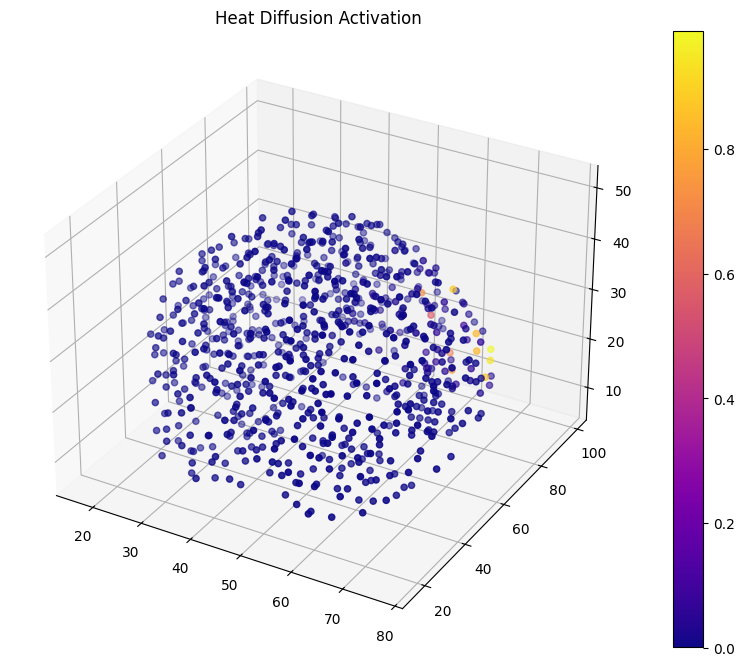

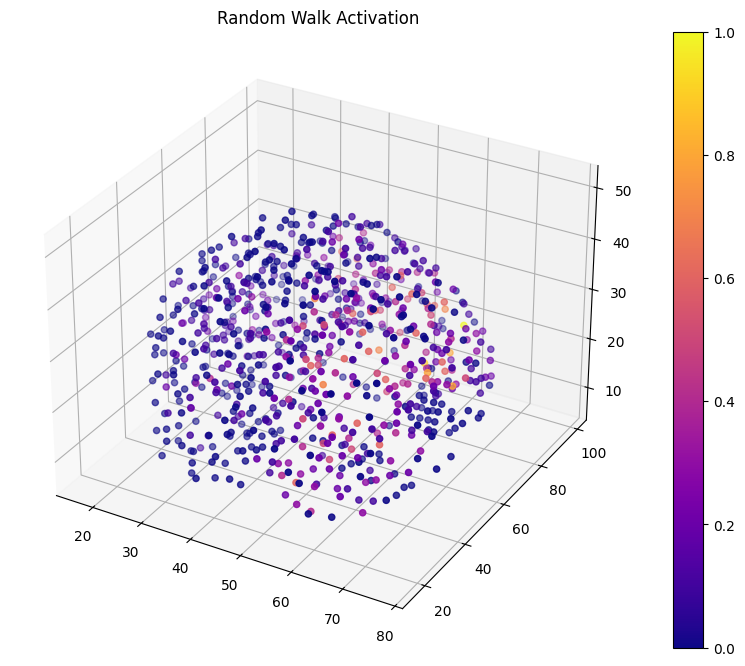

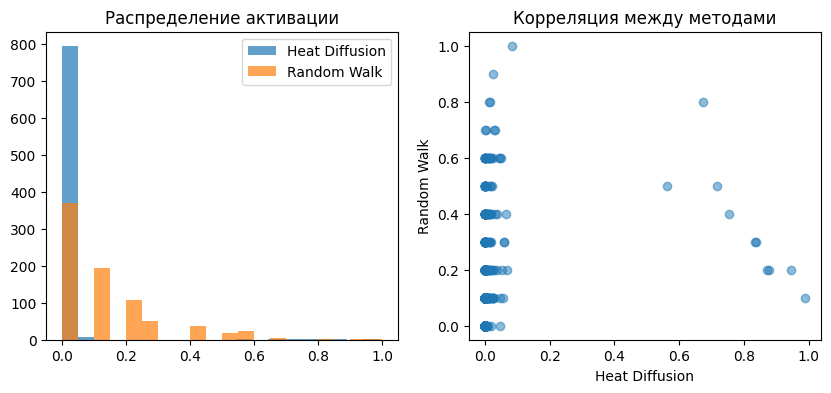

Корреляция: 0.17


In [ ]:
def find_dlpfc_nodes(graph, x_range=(48, 80), y_range=(70, 100), z_range=(20, 40)):
    dlpfc_nodes = []
    for n in graph.nodes():
        data = graph.nodes[n]
        x, y, z = data['dn_position_x'], data['dn_position_y'], data['dn_position_z']
        if (x_range[0] <= x <= x_range[1] and 
            y_range[0] <= y <= y_range[1] and 
            z_range[0] <= z <= z_range[1]):
            dlpfc_nodes.append(n)
    return dlpfc_nodes[:10]

stimulation_nodes = find_dlpfc_nodes(G)
def heat_diffusion(graph, sources, alpha=0.1, time=1.0):
    nodes = list(graph.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    
    L = nx.laplacian_matrix(graph, nodelist=nodes).astype(float)
    L = -alpha * L
    heat = np.zeros(n)
    
    for node in sources:
        heat[node_index[node]] = 1.0
    solution = expm(L * time).dot(heat)
    return {node: solution[i] for i, node in enumerate(nodes)}

def weighted_random_walk(graph, sources, steps=100):
    activation = {n: 0.0 for n in graph.nodes()}
    
    for start_node in sources:
        current = start_node
        activation[current] += 1.0
        
        for _ in range(steps):
            neighbors = list(graph.neighbors(current))
            weights = [graph[current][n]['weight'] for n in neighbors]
            total = sum(weights)
            if total == 0:
                break
            probs = [w/total for w in weights]
            current = np.random.choice(neighbors, p=probs)
            activation[current] += 1.0
    
    max_act = max(activation.values())
    return {n: act/max_act for n, act in activation.items()}

hd_result = heat_diffusion(G, stimulation_nodes)
rw_result = weighted_random_walk(G, stimulation_nodes)

def plot_3d_activation(graph, activation_dict, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    xs = [data['dn_position_x'] for _, data in graph.nodes(data=True)]
    ys = [data['dn_position_y'] for _, data in graph.nodes(data=True)]
    zs = [data['dn_position_z'] for _, data in graph.nodes(data=True)]
    colors = [activation_dict[n] for n in graph.nodes()]
    
    sc = ax.scatter(xs, ys, zs, c=colors, cmap='plasma', s=20)
    ax.set_title(title)
    plt.colorbar(sc)
    plt.show()

plot_3d_activation(G, hd_result, "Heat Diffusion Activation")
plot_3d_activation(G, rw_result, "Random Walk Activation")

def compare_methods(hd, rw):
    hd_vals = np.array(list(hd.values()))
    rw_vals = np.array(list(rw.values()))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.hist(hd_vals, bins=20, alpha=0.7, label='Heat Diffusion')
    plt.hist(rw_vals, bins=20, alpha=0.7, label='Random Walk')
    plt.legend()
    plt.title('Распределение активации')
    
    plt.subplot(122)
    plt.scatter(hd_vals, rw_vals, alpha=0.5)
    plt.xlabel('Heat Diffusion')
    plt.ylabel('Random Walk')
    plt.title('Корреляция между методами')
    plt.show()
    
    print(f"Корреляция: {np.corrcoef(hd_vals, rw_vals)[0,1]:.2f}")

compare_methods(hd_result, rw_result)

Затрагивается больше нейронов в random walk, но сильнее затрагиваются нейроны ближе в heat diffusion в обоих регионах. В dlpfc лучше корреляция методов, возможно из-за его большей сконцентрированности.